In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
# Mac OS jupyter kernel dies without.
import os

from epi.models import Model, Parameter
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

os.environ['KMP_DUPLICATE_LIB_OK']='True'

### 1. Define the model.


In [3]:
N = 20
Js_eig_max_mean = 1.5
J_eig_realmax_mean = 0.5

def stable_amplification_r2(U, V):
    U = tf.reshape(U, (-1, N, 2))
    V = tf.reshape(V, (-1, N, 2))
    J = tf.matmul(U, tf.transpose(V, [0,2,1]))
    Js = (J + tf.transpose(J, [0, 2, 1])) / 2.
    Js_eigs = tf.linalg.eigvalsh(Js)
    Js_eig_max = tf.reduce_max(Js_eigs, axis=1)
    
    # Take eig of low rank similar mat
    Jr = tf.matmul(tf.transpose(V, [0,2,1]), U)
    Jr_tr = tf.linalg.trace(Jr)
    maybe_complex_term = tf.complex(tf.square(Jr_tr) + -4.*tf.linalg.det(Jr), 0.)
    J_eig_realmax = 0.5 * (Jr_tr + tf.math.real(tf.sqrt(maybe_complex_term)))
    
    T_x = tf.stack([Js_eig_max, tf.square(Js_eig_max-Js_eig_max_mean),
                    J_eig_realmax, tf.square(J_eig_realmax-J_eig_realmax_mean)], axis=1)
    return T_x





(10000, 4)


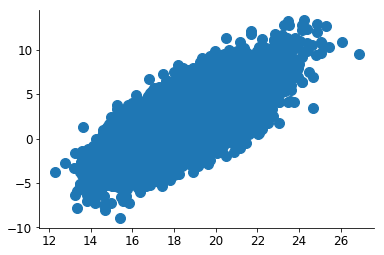

In [124]:
B = 10000
N = 100
U = np.random.uniform(-1., 1., (B, N*r,)).astype(np.float32)
V = np.random.uniform(-1., 1., (B, N*r,)).astype(np.float32)

T_x = stable_amplification_r2(U, V)
print(T_x.shape)
plt.scatter(T_x[:,0], T_x[:,2])

In [5]:
r = 2
D = N*r
lb = -np.ones((D,))
ub = np.ones((D,))
U = Parameter("U", D=D, lb=lb, ub=ub)
V = Parameter("V", D=D, lb=lb, ub=ub)

In [16]:
name = "Rank2Net"
params = [U, V]
M = Model(name, params)

In [17]:
M.set_eps(stable_amplification_r2)

In [9]:
from epi.normalizing_flows import NormalizingFlow
nf = NormalizingFlow(
    arch_type='coupling',
    D=2*D,
    num_stages=3,
    num_layers=2,
    num_units=4*D,
    batch_norm=False,
    bn_momentum=None,
    post_affine=False,
    bounds=M._get_bounds(),
    random_seed=1,
)

In [12]:
from epi.util import AugLagHPs
aug_lag_hps = AugLagHPs(500, 1e-3, 1., 0.25, 10.)

In [20]:
# Emergent property values
mu = np.array([1.5 , 0.25**2, .5, 0.25**2])

In [81]:
hp_df, opt_df = M.get_epi_dfs(mu, "")

Checking in data/Rank2Net_stable_amplification_r2_mu=1.50E+00_6.25E-02_5.00E-01_6.25E-02/.
skipping data/Rank2Net_stable_amplification_r2_mu=1.50E+00_6.25E-02_5.00E-01_6.25E-02/D20_C3_L2_U40_rs1_N500_lr1.00E-03_c0=6.00E+00_gamma2.50E-01_beta1.00E+01/hps.p
skipping data/Rank2Net_stable_amplification_r2_mu=1.50E+00_6.25E-02_5.00E-01_6.25E-02/D40_C3_L2_U80_rs1_N500_lr1.00E-03_c0=0.00E+00_gamma2.50E-01_beta1.00E+01/hps.p
skipping data/Rank2Net_stable_amplification_r2_mu=1.50E+00_6.25E-02_5.00E-01_6.25E-02/D200_C3_L2_U400_rs1_N500_lr1.00E-03_c0=0.00E+00_gamma2.50E-01_beta1.00E+01/hps.p
Found 13 optimizations.


In [103]:
opt_df['Rnorm'] = opt_df[['R%d' % i for i in range(1, 5)]].pow(2.).sum(axis=1).pow(0.5)

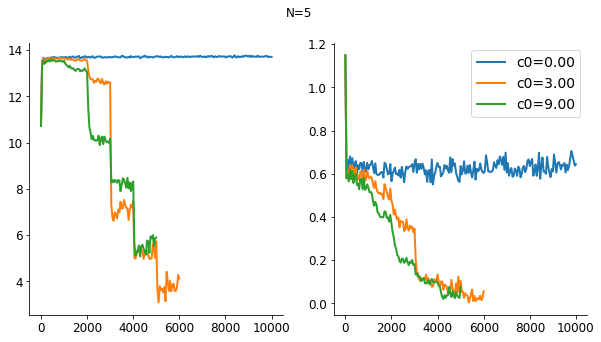

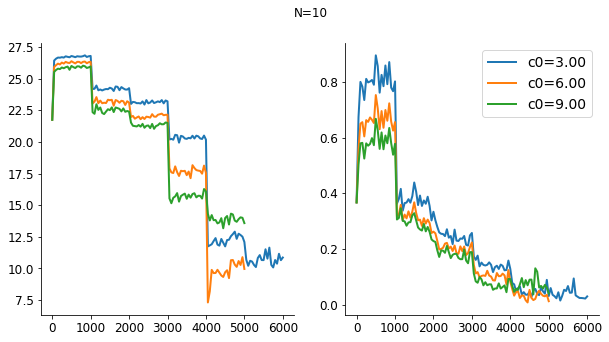

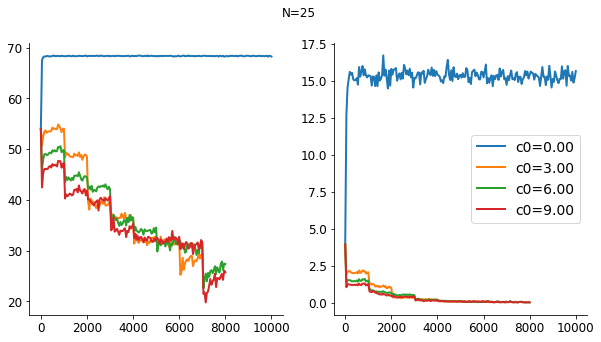

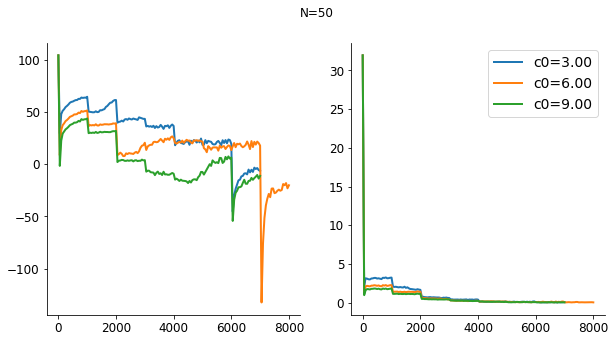

In [106]:
Ns = [5, 10, 25, 50]
c0s = [0, 3, 6, 9]
for N in Ns:
    D = 2*N*r
    D_str = 'D%d_' % D
    _opt_df = opt_df[opt_df['hp'].str.contains(D_str)].copy()
    fig, axs = plt.subplots(1,2, figsize=(10, 5))
    for c0 in c0s:
        c0_str = 'c0=%.2f' % c0
        df = _opt_df[_opt_df['hp'].str.contains(c0_str)]
        if df.shape[0] > 0:
            axs[0].plot(df['iteration'], df['H'], label=c0_str)
            axs[1].plot(df['iteration'], df['Rnorm'], label=c0_str)
    axs[1].legend()
    plt.suptitle('N=%d' % N)
    plt.show()

In [114]:
for i, hp_row in hp_df.iterrows():
    print(hp_row)
    dist = M.load_epi_dist(
        mu,
        k=1,
        arch_type=hp_row['arch_type'],
        num_stages=hp_row['num_stages'],
        num_layers=hp_row['num_layers'],
        num_units=hp_row['num_units'],
        batch_norm=hp_row['batch_norm'],
        post_affine=hp_row['post_affine'],
        N=hp_row['N'],
        lr=hp_row['lr'],
        c0=hp_row['c0'],
        gamma=hp_row['gamma'],
        beta=hp_row['beta'],
    )
    break

arch_type      coupling
num_stages            3
num_layers            2
num_units           200
batch_norm        False
bn_momentum        None
post_affine       False
random_seed           1
N                   500
lr                0.001
c0                    3
gamma              0.25
beta                 10
H               29.1405
Name: 1, dtype: object


TypeError: load_epi_dist() got multiple values for argument 'k'